In [3]:
!pip install tensorflow
!pip install keras
!pip install scikeras
!pip install xgboost
!pip install imblearn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import xgboost as xgb

In [5]:
data = pd.read_csv('./cleaned_data_2.csv')

In [6]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

#TRUE/FALSE becomes 1/0
X = X.replace({'TRUE': 1, 'FALSE': 0})

In [7]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Apply Label Encoding to categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [8]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# SMOTE to handle imbalanced samples
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [10]:
# Design the autoencoder
input_dimension = X_train_resampled.shape[1]
encoding_dimension = input_dimension // 2  

# Autoencoder architecture
input_layer = Input(shape=(input_dimension,))

encoder = Dense(encoding_dimension, activation='relu')(input_layer)
decoder = Dense(input_dimension, activation='linear')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Training autoencoder with early stopping mechanism
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_train_resampled, X_train_resampled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop],
    validation_data=(X_test, X_test)
)

# encoded features are extracted
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train_resampled)
X_test_encoded = encoder_model.predict(X_test)

Epoch 1/50


2024-12-10 01:01:50.183326: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.
2024-12-10 01:01:50.250646: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


3976/3976 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 370.9029 - val_loss: 0.2830
Epoch 2/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.2578 - val_loss: 0.1784
Epoch 3/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.1660 - val_loss: 0.1315
Epoch 4/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1203 - val_loss: 0.1221
Epoch 5/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1058 - val_loss: 0.1005
Epoch 6/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0948 - val_loss: 0.0743
Epoch 7/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0891 - val_loss: 0.0728
Epoch 8/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0780 - val_loss: 0.0642
Epoch 9/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0723 - val_loss: 0.0647
Epoch 10/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0665 - val_loss: 0.0640
Epoch 11/50
3976/3976 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0612 - val_loss: 0.0536
Epoch 12/50
3976/3976 ━━━━━━━━━━━━━━━━

2024-12-10 01:07:56.121132: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 39692328 exceeds 10% of free system memory.


3976/3976 ━━━━━━━━━━━━━━━━━━━━ 3s 778us/step
994/994 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step


In [11]:
baseline_xgb = xgb.XGBClassifier(
    n_estimators=100,         
    max_depth=6,             
    learning_rate=0.1,         
    subsample=1.0,             
    colsample_bytree=1.,      
    objective='binary:logistic',
    eval_metric='logloss'
)


In [15]:
baseline_xgb.fit(X_train_encoded, y_train_resampled)
y_pred = baseline_xgb.predict(X_test_encoded)
y_pred_proba = baseline_xgb.predict_proba(X_test_encoded)[:, 1]


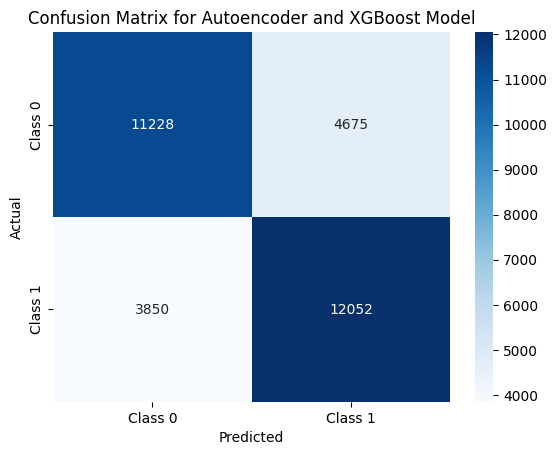

Accuracy: 0.73
Precision: 0.72
Recall: 0.76
F1-Score: 0.74
AUC-ROC: 0.81


In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title(f"Confusion Matrix for Autoencoder and XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

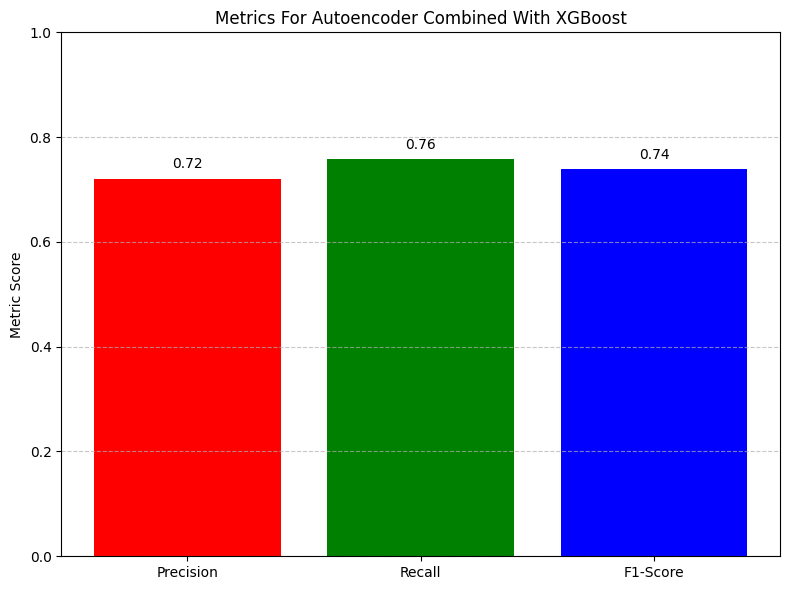

In [17]:
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['red', 'green', 'blue'])

plt.ylabel('Metric Score')
plt.title('Metrics For Autoencoder Combined With XGBoost')
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(values):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
!pip install shap --upgrade
!pip install lime


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


100%|===================| 31730/31805 [03:34<00:00]        

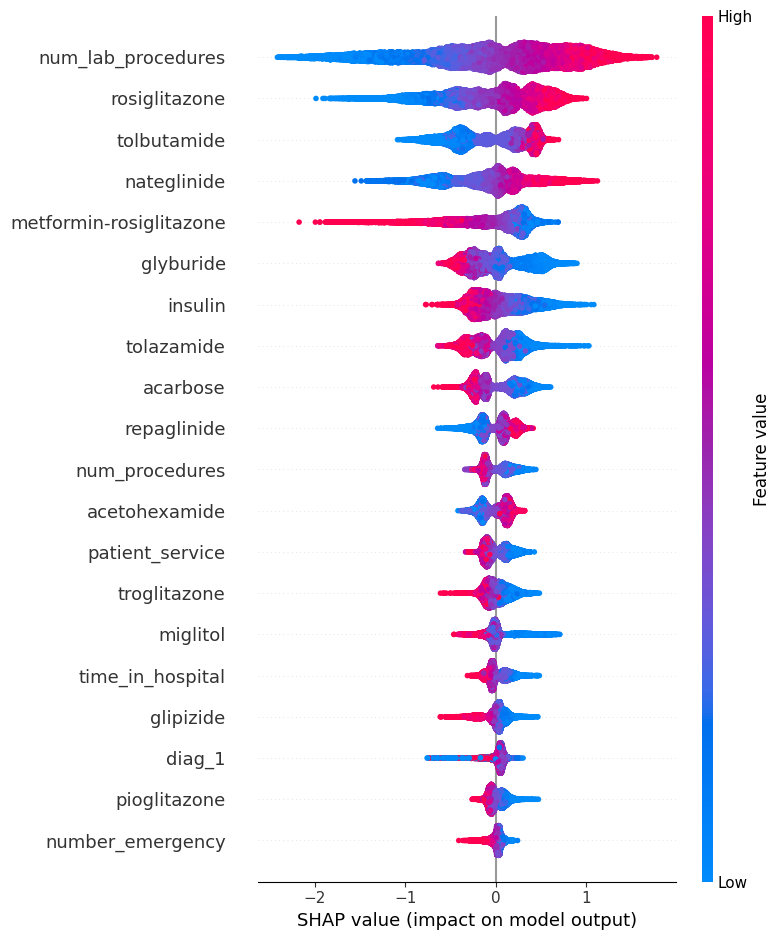

In [20]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

explainer = shap.Explainer(baseline_xgb, X_train_encoded)
shap_values = explainer(X_test_encoded)
shap.summary_plot(shap_values, X_test_encoded, feature_names=X.columns)

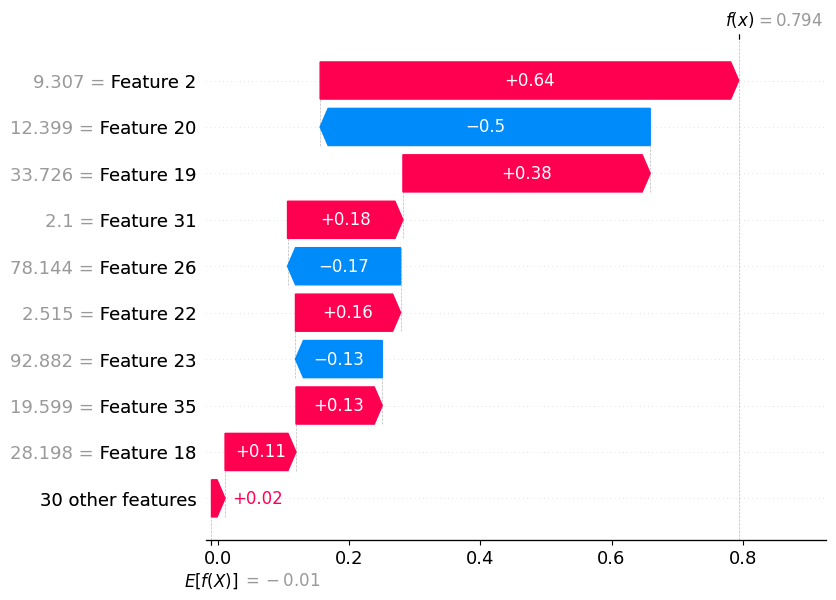

In [21]:
single_index = 0 
shap.waterfall_plot(shap_values[single_index])

lime_explainer = LimeTabularExplainer(
    training_data=X_train_encoded,
    feature_names=X.columns.tolist(), 
    class_names=["Not Readmitted", "Readmitted"],
    mode='classification'
)

instance_to_explain = X_test_encoded[single_index] 

lime_exp = lime_explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=baseline_xgb.predict_proba
)

lime_exp.show_in_notebook()